<a href="https://colab.research.google.com/github/AlexanderOnbysh/edu/blob/master/masters/machine-learning/Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to unsupervised learning 

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.


## Homework #2

This colaboratory also contains Homework #2 which is due **March 5 midnight (23:59 EET time)**. To complete the homework, extract **(File -> Download .ipynb)** and submit to the course webpage.

**NB! Links to your colaboratory will not be accepted as a solution!**

### Setup: 
Here we will load necessary libraries (NumPy, Pandas and loading and visualising MNIST handwritten digits 

In [32]:
# The three giants on which everything else is built
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Ready made stuff lives here:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

# We don't like warnings
import warnings
warnings.filterwarnings('ignore')

# For plotting like a pro
!pip install plotnine
from plotnine import *

# Not sure why we need this
import os

# MNIST lives here:
from tensorflow.examples.tutorials.mnist import input_data

# Curse of dimensionality (part I)
Distances in high dimensional spaces become more similar (MNIST example)

In [33]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
images = np.vstack([img.reshape(-1,) for img in mnist.train.images])
labels = mnist.train.labels
print(f"images are of shape: {images.shape} and labels: {labels.shape}")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
images are of shape: (55000, 784) and labels: (55000,)


In [0]:
def dist(img1, img2):
  return( np.sqrt(np.sum(np.abs(img1 - img2)**2)))

In [0]:
train_images = images[0:2000,:]
train_labels = labels[0:2000]

test_images = images[2000:3000,:]
test_labels = labels[2000:3000]

Let's calculate euclidean distances between all images in the training data and store them in a matrix

In [0]:
distanceMatrix = np.array([np.linalg.norm(image - train_images[:,None], axis=-1) for image in train_images]).reshape((2000,2000))
distanceMatrix[np.diag_indices(distanceMatrix.shape[0])] = float('inf')

In case you were wondering how efficient `numpy` implementations comparing to naïve handmade code, running the following cell can give you some idea. If self-torture is not your thing, skip it.

In [0]:
distanceMatrix = np.zeros((len(train_images), len(train_images)))

for i in np.arange(len(train_images)):
  for j in np.arange(len(train_images)):
    if i == j:
      distanceMatrix[i,j] = float('inf')
    else:
      distanceMatrix[i,j] = dist(train_images[i], train_images[j])

Here comes weirdly looking and hard to understand code that takes a random image from `train_images` and prints out a series of images that are closest in the euclidean space. Play around with the output by re-running this cell miltiple times.

1370


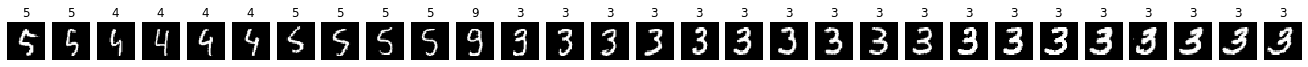

In [38]:
plt.rcParams['figure.figsize'] = (24.0, 12.0) # set default size of plots
# "Names" of classes:
classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#start_id = np.random.choice(np.arange(len(train_images)), 1, replace=False)
start_id = 1370 # an interesting case
print(start_id)
n_images = 30

plt.subplot(1, 1, 1)
plt.imshow(train_images[start_id].reshape((28, 28)), plt.get_cmap('gray'))
plt.axis('off')

curr_id = start_id
idx = np.zeros(n_images)
idx[0] = curr_id
new_id = -1

for i in (np.arange(n_images-1)+1):
  plt_idx = i
  plt.subplot(1, n_images, (plt_idx + 1))
  closest_idx = np.argsort(distanceMatrix[:,curr_id].flatten())
  
  for j in closest_idx:
    if not j in idx:
      new_id = j
      break
  
  if new_id == -1:
    break

  plt.imshow(train_images[new_id].reshape((28, 28)), plt.get_cmap('gray'))
  plt.axis('off')
  plt.title(train_labels[new_id])
  curr_id = new_id
  idx[i] = curr_id
  new_id = -1

plt.show()

Next we can see couple of images that are on the equal distances from each other in the euclidean space

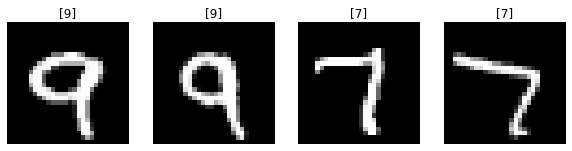

In [39]:
ids = np.argwhere(np.round(distanceMatrix[0,:], 1) == 8.6)

plt.rcParams['figure.figsize'] = (10, 8.0) # set default size of plots

for i in np.arange(len(ids)):
  plt_idx = i
  plt.subplot(1, len(ids), plt_idx + 1)
  plt.imshow(train_images[ids[i]].reshape((28, 28)), plt.get_cmap('gray'))
  plt.axis('off')
  plt.title(train_labels[ids[i]])

plt.show()

# Curse of dimensionality (part II)
Here we will illustrate how increasing the dimensionality of your data (adding more features) may impact the performance of the machine learning model.

We generate 100 points from 50 dimensional Gaussian distribution. Fifty points are generated from a distribution centered at 1 and another fifty from a distribution with a centre in 0.

In [0]:
np.random.seed(2342347823) # random seed for consistency

D = 50

# Generating 50 points for the first class
mu_vec1 = np.zeros(D) 
cov_mat1 = np.eye(D) # creates a diagonal matrix of size D x D, all values except diagonal are 0
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 50)

# Generating 50 points for the second class
mu_vec2 = np.ones(D)
cov_mat2 = np.eye(D)
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 50)

Combine two samples together into one dataset

In [0]:
train = np.concatenate((class1_sample, class2_sample), axis=0)
train_data = pd.DataFrame(train)

# Create names for columns, x1, x2 ... x50
train_data.columns = [ 'x' + str(i) for i in (np.arange(D)+1)]

# Create a class column
train_data['class'] = np.concatenate((np.repeat(0, 50), np.repeat(1, 50)))

# This is important for plotting and modelling
train_data['class'] = train_data['class'].astype('category')

Divide this dataset into two sets: training set (60%) and validation set (40%). As we have done in the previous practice.

In [0]:
##### YOUR CODE STARTS #####
train = train_data[:int(0.6*(len(train_data)))]
val = train_data[int(0.6*(len(train_data))):]
##### YOUR CODE ENDS ##### (please do not delete this line)

Visualise training data

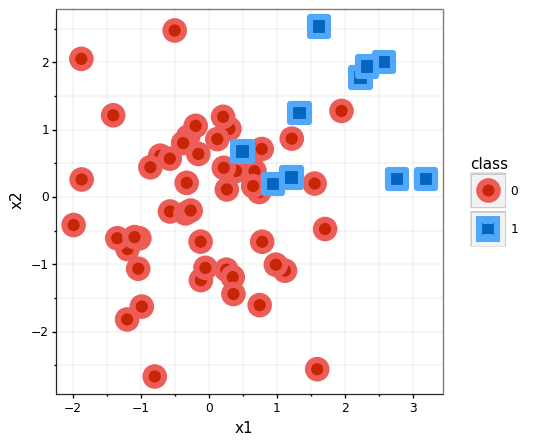

<ggplot: (8773781128568)>

In [43]:
fig = (
    ggplot(data = train,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

There are way more instances on the class 0 than instances of class 1. What is wrong?

In [0]:
from sklearn.model_selection import train_test_split
##### YOUR CODE STARTS #####
train, val = train_test_split(train_data, random_state = 111, test_size = 0.4) 
##### YOUR CODE ENDS ##### (please do not delete this line)

Visualise the training data again to make sure that now we managed to get balanced representation

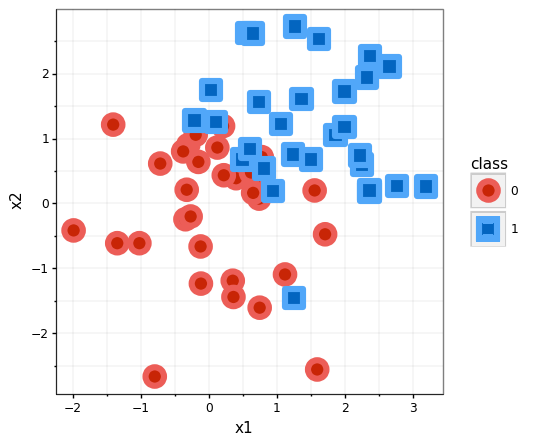

<ggplot: (8773781128582)>

In [45]:
fig = (
    ggplot(data = train,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Well done! What about the validation set?

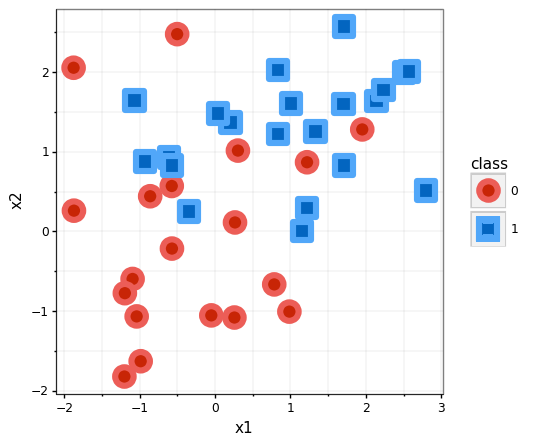

<ggplot: (-9223363263073669148)>

In [46]:
fig = (
    ggplot(data = val,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Let's see how the Decision Tree algorithm can cope with this data. Let's import the Decision Tree from the `sklearn` package.

In [0]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 5) 

Train a DecisionTreeClassifier on 2D data and test it on validation data (we shall not use CV algorithm in this case to save time)

In [48]:
# 2D data
##### YOUR CODE STARTS #####
model.fit(train[['x1', 'x2']], train['class'])
val_accuracy = np.sum(model.predict(val[['x1','x2']]) == val['class'])/len(val)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 80.0%


Now let's do the same for 5D and 50D data

In [49]:
##### YOUR CODE STARTS #####
# 5D data
model.fit(train.iloc[:,:5], train['class'])
val_accuracy = np.sum(model.predict(val.iloc[:,:5]) == val['class'])/len(val)
print(f"Validation accuracy is {val_accuracy*100}%")
##### YOUR CODE ENDS ##### (please do not delete this line)

Validation accuracy is 72.5%


In [50]:
##### YOUR CODE STARTS #####
# 50D data
model.fit(train.iloc[:,:50], train['class'])
val_accuracy = np.sum(model.predict(val.iloc[:,:50]) == val['class'])/len(val)
print(f"Validation accuracy is {val_accuracy*100}%")
##### YOUR CODE ENDS ##### (please do not delete this line)

Validation accuracy is 67.5%


What is going on here? Let's visualise our validation set along with predicted classes.

In [51]:
model.fit(train[['x1','x2']], train['class'])

# 2D data
validation_accuracy = np.sum(model.predict(val[['x1','x2']]) == val['class'])/val.shape[0]
print(f"Validation accuracy is {validation_accuracy*100}%")

val['predicted'] = model.predict(val[['x1','x2']])
val['predicted'] = val['predicted'].astype('category')

Validation accuracy is 80.0%


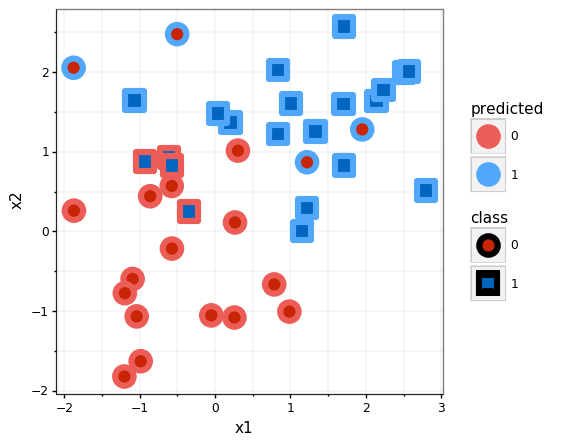

<ggplot: (8773781126271)>

In [52]:
fig = (
    ggplot(data = val,
          mapping = aes(x = 'x1', y = 'x2')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x1',
        y = 'x2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

# Curse of dimensionality (part III)
The assumption is that under the curse of dimensionality the expected smallest distance between points increases (points in high-dimensional space are further apart) exponentially with number of dimensions. Here we will try to demonstrate this phenomenon experimentaly. 

Let's sample 14 points from 1D uniform distribution:


In [0]:
oneD = np.random.rand(14,1)*6 # here I multiply by 6 just to force values into a range from 0 to 6

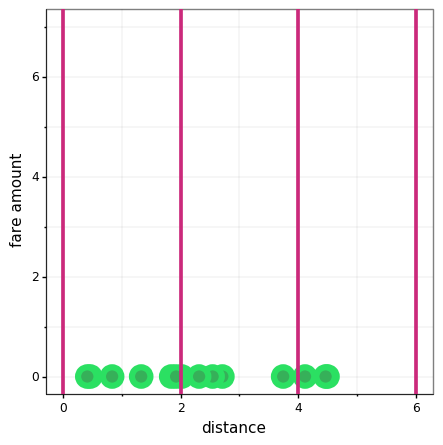

<ggplot: (8773782096297)>

In [54]:
# Converting oneD into pandas DataFrame before visualising
example_data = pd.DataFrame({'x':np.transpose(oneD)[0], 'y':np.zeros_like(np.transpose(oneD)[0])})

fig = (
    ggplot(data = example_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'distance',
        y = 'fare amount',
    ) +
    xlim(0, 6) +
    ylim(0, 7) +
    theme_bw() + 
    geom_vline( xintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Again sampling 14 points, now from uniform 2D distribution

In [0]:
twoD = np.random.rand(14,2)*6

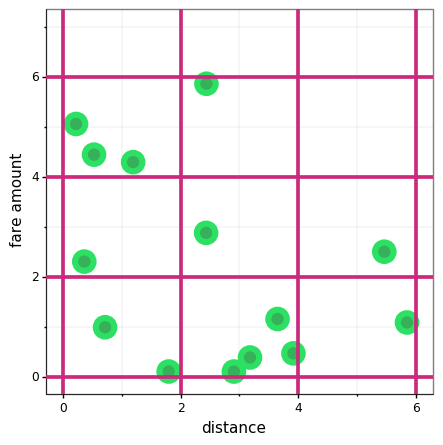

<ggplot: (8773781128838)>

In [56]:
example_data = pd.DataFrame({'x':np.transpose(twoD)[0], 'y':np.transpose(twoD)[1]})
fig = (
    ggplot(data = example_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'distance',
        y = 'fare amount',
    ) +
    xlim(0, 6) +
    ylim(0, 7) +
    theme_bw() + 
    geom_vline( xintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) + 
    geom_hline( yintercept = (0, 2, 4, 6), color="#CB297B", size=1.5) +
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Let's calculate and compare minimum dsistances between points in 1D and 2D.

In [57]:
oneD_distances = np.array([np.linalg.norm(point - oneD[:,None], axis=-1) for point in oneD])
print(oneD_distances.shape)
print(oneD_distances[:5,:5])

(14, 14, 1)
[[[0.        ]
  [1.72489873]
  [1.90687956]
  [2.41845579]
  [1.8236312 ]]

 [[1.72489873]
  [0.        ]
  [0.18198083]
  [0.69355707]
  [0.09873247]]

 [[1.90687956]
  [0.18198083]
  [0.        ]
  [0.51157623]
  [0.08324836]]

 [[2.41845579]
  [0.69355707]
  [0.51157623]
  [0.        ]
  [0.59482459]]

 [[1.8236312 ]
  [0.09873247]
  [0.08324836]
  [0.59482459]
  [0.        ]]]


We will use `triu_indices` function (with an offset 1 from the main diagonal) to extract upper triangle of the distance matrix and take minimum of these

In [58]:
##### YOUR CODE STARTS #####
min1D_distance = np.min(oneD_distances[np.triu_indices(len(oneD), k = 1)])
##### YOUR CODE ENDS ##### (please do not delete this line)
print(min1D_distance)

0.0319748622435343


Let's do the same procedure for 2D points (`twoD`):

In [59]:
##### YOUR CODE STARTS #####
twoD_distances = np.array([np.linalg.norm(point - twoD[:,None], axis=-1) for point in twoD])
min2D_distance = np.min(twoD_distances[np.triu_indices(len(twoD), k = 1)])
##### YOUR CODE ENDS ##### (please do not delete this line)
print(min2D_distance)

0.39255750323880223


It has increased by at least one order of magnitude!

Make a function that samples a given number of points with a fixed number of dimensions from the random distribution and then calculates the minimum distance between these points (copy and paste from already created code).

In [0]:
##### YOUR CODE STARTS #####
def compute_min_distance(n_points, n_dimensions):
  points = np.random.rand(n_points, n_dimensions)*6
  distances = np.array([np.linalg.norm(point - points[:,None], axis=-1) for point in points])
  min_distance = np.min(distances[np.triu_indices(len(points), k = 1)])
  return(min_distance)
##### YOUR CODE ENDS ##### (please do not delete this line)


What about minimum smallest distance between points in 3D space?

In [61]:
min3D_distance = compute_min_distance(14, 3)
print(min3D_distance)

0.798420069201549


## Homework exercise 1 (3 points): Curse of dimensionality applied to sampling density

<font color='red'>**(a)** When dealing with sampling random distributions one needs to be careful as variation between samples can be very large. Compute minimum distance in each space (1D, 2D and 3D) at least 1000 times. Store minimum distances from each space in its own variable (mins1D, mins2D and mins3D). For each space report the average smallest distance and confirm that these distances grow with number of dimensions. **(1 point)** </font> 

In [66]:
##### YOUR CODE STARTS #####
n_runs = 1000
mins1D = [compute_min_distance(14, 1) for _ in range(n_runs)]
mins2D = [compute_min_distance(14, 2) for _ in range(n_runs)]
mins3D = [compute_min_distance(14, 3) for _ in range(n_runs)]
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f'the average smallest distance in 1D is {np.mean(mins1D)}')
print(f'the average smallest distance in 2D is {np.mean(mins2D)}')
print(f'the average smallest distance in 3D is {np.mean(mins3D)}')

the average smallest distance in 1D is 0.031625224492137
the average smallest distance in 2D is 0.3184270253385107
the average smallest distance in 3D is 0.7733966553826994


<font color='red'>**(b)** According to elements of statistical learning (https://web.stanford.edu/~hastie/Papers/ESLII.pdf), sampling density is proportional to N^D. Therefore If we want to have the same expected smallest distance between points in 2D as we had in 1D space with 14 points (~0.02), we would need to generate 14^2 points (196 points) in 2D or 14^3 in 3D. Test this hipothesis by sampling corresponding number of points in each space and calculating the average smallest distances. (2 points) </font>


NB! probably it makes sense to decrease the number of runs to ~100.

In [68]:
##### YOUR CODE STARTS #####
n_runs = 100
mins1D = [compute_min_distance(14, 1) for _ in range(n_runs)]
mins2D = [compute_min_distance(14 ** 2, 2) for _ in range(n_runs)]
mins3D = [compute_min_distance(14 ** 3, 3) for _ in range(n_runs)]
##### YOUR CODE ENDS ##### (please do not delete this line)

print(f'the average smallest distance in 1D is {np.mean(mins1D)}')
print(f'the average smallest distance in 2D is {np.mean(mins2D)}')
print(f'the average smallest distance in 3D is {np.mean(mins3D)}')


the average smallest distance in 1D is 0.034781424629815205
the average smallest distance in 2D is 0.021947863014875123
the average smallest distance in 3D is 0.021342351623050416


<font color='red'>**(c)** Comment on obtained results. (1 point) </font>

Answer to **(c)**: 
In the second experiment when we sample $N^D$ samples for $D$ dimensional space the average min distance rougthly equals for each dimension. So, statistics is a helpful thing :)

Go to the slides!

# Principle Component Analysis (toy data)
Generate data from the lecture slides

In [0]:
Z = pd.DataFrame({'x':[1,2,3,4,5], 'y':[2,4,5,4,5]})

# Centering both features
Z.x = Z.x - Z.x.mean()
Z.y = Z.y - Z.y.mean()

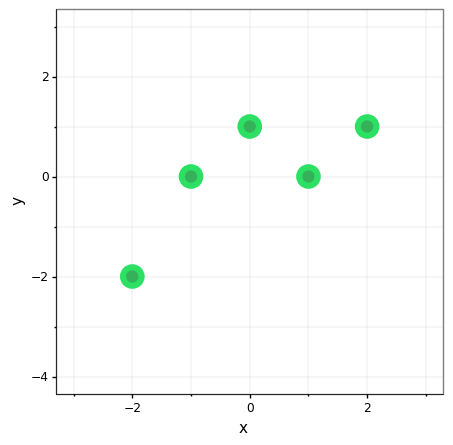

<ggplot: (8773785222783)>

In [70]:
fig = (
    ggplot(data = Z,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Transpose the matrix of original coordinates

In [71]:
Z = np.matrix(Z)
Z_t = Z.T
print(Z)
print(Z_t)

[[-2. -2.]
 [-1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 2.  1.]]
[[-2. -1.  0.  1.  2.]
 [-2.  0.  1.  0.  1.]]


Compute covariance matrix

In [72]:
##### YOUR CODE STARTS #####
S = np.dot(Z_t, Z)/4
##### YOUR CODE ENDS ##### (please do not delete this line)
print(S)

[[2.5 1.5]
 [1.5 1.5]]


Perform eigendecomposition using `linalg.eig` function from `numpy`

In [73]:
 w, v = np.linalg.eig(S)
 print(w)
 print(-1*v)

[3.58113883 0.41886117]
[[-0.81124219  0.58471028]
 [-0.58471028 -0.81124219]]


Transform transposed matrix of original coordinates into the space of principle components.

In [74]:
Z_new = np.matmul((-1*v).T, Z_t) # we need to transpose eigenvectors here due to implementation details of linalg.eig

# Make it actually look nice
Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':np.array(Z_new)[1]})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


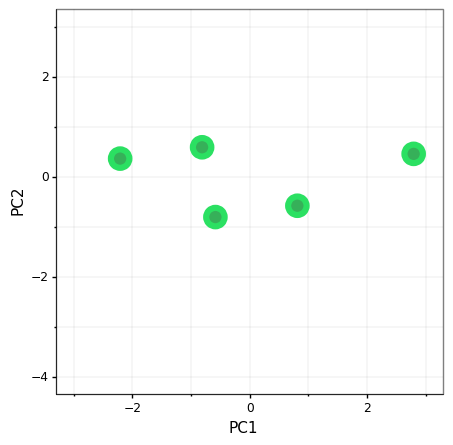

<ggplot: (8773785380374)>

In [75]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## PCA with `sklearn`
Of course, you guessed it, `sklearn` can do it for you.

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #choose the number of components = number of original dimensions

# use PCA on our data
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [77]:
##### YOUR CODE STARTS #####
pca_v = np.matrix(pca.components_)
pca_w = pca.explained_variance_
##### YOUR CODE ENDS ##### (please do not delete this line)

print(pca_v)
print(pca_w)

[[-0.81124219 -0.58471028]
 [-0.58471028  0.81124219]]
[3.58113883 0.41886117]


Transform the original matrix with `sklearn` derived values:

In [78]:
##### YOUR CODE STARTS #####
Z_new = np.matmul(pca_v, Z_t) # note that here we don't need to transpose eigenvectors
##### YOUR CODE ENDS ##### (please do not delete this line)

Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':(-1*np.array(Z_new)[1])})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


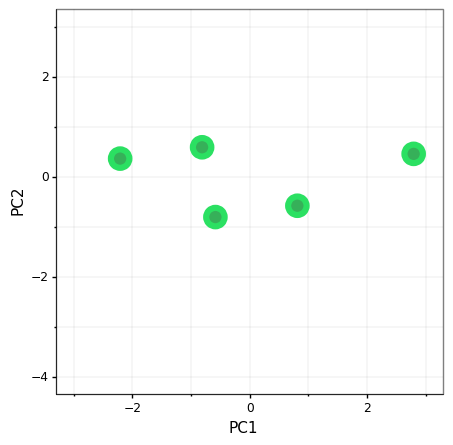

<ggplot: (-9223363263069395375)>

In [79]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## Shorter way to use PCA from `sklearn`

In [0]:
pca = PCA(n_components=2)
Z_new = pca.fit_transform(Z).T

That is it :)

In [81]:
Z_new_pd = pd.DataFrame({'PC1':np.array(Z_new)[0], 'PC2':(-1*np.array(Z_new)[1])})
print(Z_new_pd)

        PC1       PC2
0  2.791905  0.453064
1  0.811242 -0.584710
2 -0.584710 -0.811242
3 -0.811242  0.584710
4 -2.207195  0.358178


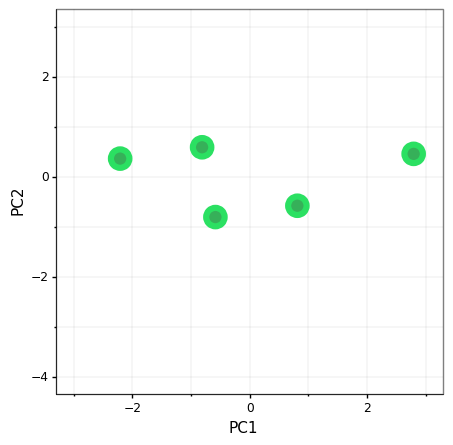

<ggplot: (8773781052024)>

In [82]:
fig = (
    ggplot(data = Z_new_pd,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    xlim(-3, 3) +
    ylim(-4, 3) +
    theme_bw() + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Let's go back to the lecture! Come back here after the variance explained slides.

# PCA can improve ML performance on high-dimensional data
Let's see how PCA can help us first to compress the original 50D data and secondly enable the Decision Tree algorithm perform better.

First, some simple preprocessing.


In [0]:
# we need to drop class variable (we will still have it stored in train)
train_Z = train.drop('class', axis = 1)

# subtract mean from each column
train_Z = train_Z - train_Z.mean()

Let's do the PCA on training data

In [0]:
pca = PCA(n_components=D)

# Fit PCA on train_Z
pca.fit(train_Z)

# Transform the original coordinates into PC space
train_Z_new = np.matmul(pca.components_, train_Z.T)

## Quantifying variance explained by PCs

Here, we will try to estimate the number of principle components that are needed to explain 90% of variance (read information) in our data. Let's print out `explained_variance_` attribute of our `pca` object.

In [85]:
print(np.round(pca.explained_variance_, 3))

[13.688  3.822  3.196  2.817  2.634  2.57   2.459  2.157  2.069  2.007
  1.821  1.691  1.564  1.477  1.466  1.451  1.337  1.223  1.194  1.107
  1.011  0.919  0.806  0.757  0.706  0.674  0.66   0.561  0.499  0.473
  0.436  0.395  0.366  0.35   0.285  0.276  0.252  0.201  0.185  0.171
  0.156  0.137  0.101  0.093  0.073  0.046  0.037  0.034  0.018  0.015]


We can divide each value by the sum of all variances to figure out the precentages

In [86]:
##### YOUR CODE STARTS #####
print(np.round(pca.explained_variance_/np.sum(pca.explained_variance_), 3))
##### YOUR CODE ENDS ##### (please do not delete this line)

[0.219 0.061 0.051 0.045 0.042 0.041 0.039 0.035 0.033 0.032 0.029 0.027
 0.025 0.024 0.023 0.023 0.021 0.02  0.019 0.018 0.016 0.015 0.013 0.012
 0.011 0.011 0.011 0.009 0.008 0.008 0.007 0.006 0.006 0.006 0.005 0.004
 0.004 0.003 0.003 0.003 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.    0.   ]


Or we can use a handy attribute `explained_variance_ratio_` to avoid this pain.

In [87]:
print(np.round(pca.explained_variance_ratio_, 3))

[0.219 0.061 0.051 0.045 0.042 0.041 0.039 0.035 0.033 0.032 0.029 0.027
 0.025 0.024 0.023 0.023 0.021 0.02  0.019 0.018 0.016 0.015 0.013 0.012
 0.011 0.011 0.011 0.009 0.008 0.008 0.007 0.006 0.006 0.006 0.005 0.004
 0.004 0.003 0.003 0.003 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.    0.   ]


How many PCs need to be retained in order to explain 90% or more variance of the original data?

In [88]:
variances = pca.explained_variance_ratio_
##### YOUR CODE STARTS #####
com_vars = [np.sum(variances[:i])for i in np.arange(len(variances)) + 1]
print(np.round(com_vars, 3))
smallest_pc_num = np.min(np.where(np.array(com_vars) > 0.9))
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'The smallest number of PCs that explain more than 90% of variance is {smallest_pc_num} out of {len(pca.explained_variance_ratio_)}')

[0.219 0.28  0.332 0.377 0.419 0.46  0.499 0.534 0.567 0.599 0.628 0.655
 0.681 0.704 0.728 0.751 0.772 0.792 0.811 0.829 0.845 0.86  0.873 0.885
 0.896 0.907 0.917 0.926 0.934 0.942 0.949 0.955 0.961 0.967 0.971 0.976
 0.98  0.983 0.986 0.989 0.991 0.993 0.995 0.996 0.998 0.998 0.999 0.999
 1.    1.   ]
The smallest number of PCs that explain more than 90% of variance is 25 out of 50


Let's first visualise first two principle components

In [0]:
train_Z_new = pd.DataFrame({'PC1':np.array(train_Z_new)[0], 'PC2':np.array(train_Z_new)[1], 'class': train['class']})

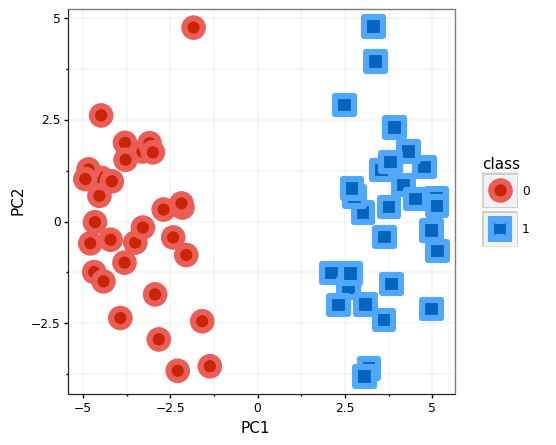

<ggplot: (8773785175756)>

In [90]:
fig = (
    ggplot(data = train_Z_new,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Performing with validation set all the same operations we performed on train

In [0]:
val_Z = val.drop(['class', 'predicted'], axis = 1)
val_Z = val_Z - val_Z.mean()
val_Z_new = np.matmul(pca.components_, val_Z.T)
val_Z_new = pd.DataFrame({'PC1':np.array(val_Z_new)[0], 'PC2':np.array(val_Z_new)[1], 'class': val['class']})

Now we can train the model and test its accuracy on validation set

In [92]:
model = DecisionTreeClassifier(max_depth = 5) 
model.fit(train_Z_new[['PC1','PC2']], train_Z_new['class'])

val_accuracy = np.sum(model.predict(val_Z_new[['PC1','PC2']]) == val_Z_new['class'])/val_Z_new.shape[0]
print(f"Validation accuracy is {val_accuracy*100}%")

Validation accuracy is 100.0%


Wow, that is impressive, but kinda unbelievable, let's visualise! (seeing is believing)

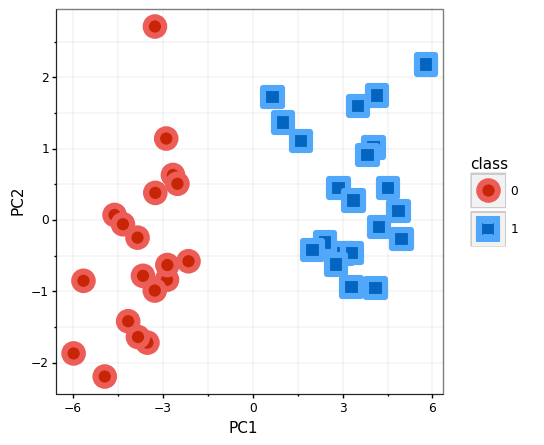

<ggplot: (-9223363263069707383)>

In [93]:
fig = (
    ggplot(data = val_Z_new,
          mapping = aes(x = 'PC1', y = 'PC2')) +
    geom_point(aes(colour = 'class', 
                   shape = 'class',
                   fill = 'class'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'PC1',
        y = 'PC2',
    ) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (5, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig 

Not bad!

### Getting our raw data back after PCA

In [94]:
# Conventional PCA
train_Z_new = pca.fit_transform(train_Z).T

##### YOUR CODE STARTS #####
train_Z_original = np.matmul(pca.components_.T, train_Z_new).T
##### YOUR CODE ENDS ##### (please do not delete this line)

print(np.round(train_Z_original, 2)[:5,:5])
np.matrix(np.round(train_Z, 2))[:5,:5]

[[ 0.   -2.09  1.02 -0.83  0.21]
 [-0.35 -0.1   0.78 -1.48 -2.33]
 [-0.86 -1.72 -0.39 -0.5  -0.67]
 [ 0.61  1.12  0.94  0.84  1.5 ]
 [ 0.52  2.24 -0.06  0.9   0.45]]


matrix([[ 0.  , -2.09,  1.02, -0.83,  0.21],
        [-0.35, -0.1 ,  0.78, -1.48, -2.33],
        [-0.86, -1.72, -0.39, -0.5 , -0.67],
        [ 0.61,  1.12,  0.94,  0.84,  1.5 ],
        [ 0.52,  2.24, -0.06,  0.9 ,  0.45]])

## Homework exercise 2 (8 points): PCA on MNIST

<font color='red'>**(a)** Perform a PCA (you can use sklearn) on MNIST data. (2 point)

In [0]:
# Centring
train_images = pd.DataFrame(np.matrix(train_images))
train_images = train_images - train_images.mean()

test_images = pd.DataFrame(np.matrix(test_images))
test_images = test_images - test_images.mean()

In [103]:
##### YOUR CODE STARTS #####
pca = PCA()
train_images_new = pca.fit_transform(train_images).T

##### YOUR CODE ENDS ##### (please do not delete this line)
print(train_images_new.shape) # this should be (784, 2000)

(784, 2000)


<font color='red'>**(b)** Plot PCA on MNIST, colour dots based on their class.
(1 point) </font>

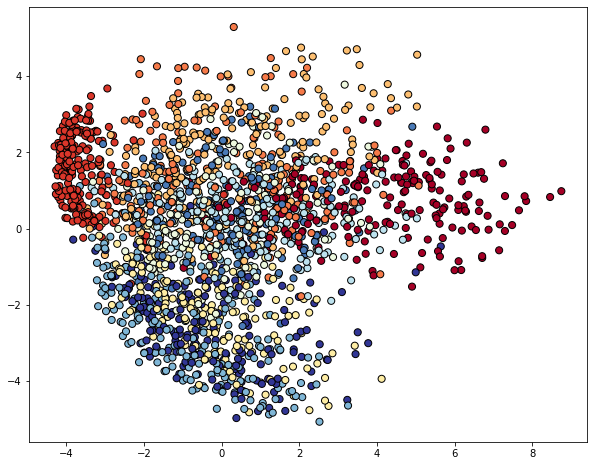

In [105]:
##### YOUR CODE STARTS #####
visualise_train = pd.DataFrame({'PC1':np.array(train_images_new)[0], 'PC2':np.array(train_images_new)[1]})
##### YOUR CODE ENDS ##### (please do not delete this line)

cm = plt.cm.get_cmap('RdYlBu')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.scatter(visualise_train.PC1, visualise_train.PC2, s=50, edgecolors = 'black', cmap=cm, c=train_labels)
plt.show()

<font color='red'>**(c)** Estimate number of principle components that heed to be retained. (1 point)
</font>

In [107]:
##### YOUR CODE STARTS #####
variances = pca.explained_variance_ratio_
com_vars = [np.sum(variances[:i])for i in np.arange(len(variances)) + 1]
print(com_vars)
n_pc = np.min(np.where(np.array(com_vars) > 0.9))
##### YOUR CODE ENDS ##### (please do not delete this line)
print(n_pc)

[0.11102764, 0.18544835, 0.25086132, 0.30958846, 0.3572814, 0.40171957, 0.43435928, 0.46369296, 0.49107233, 0.51541775, 0.53638715, 0.55645776, 0.5739759, 0.5908177, 0.6067112, 0.62131274, 0.634081, 0.64617074, 0.6578391, 0.668562, 0.67868, 0.68852127, 0.6982145, 0.70724905, 0.71556544, 0.72343105, 0.7311354, 0.7385594, 0.74536437, 0.7520876, 0.75852394, 0.7647277, 0.770634, 0.77623934, 0.7816498, 0.7869065, 0.79181695, 0.79658866, 0.8012269, 0.80566996, 0.8099186, 0.8139804, 0.81781876, 0.82159746, 0.82522863, 0.828684, 0.83205557, 0.8353729, 0.83856004, 0.8416622, 0.84452987, 0.8473437, 0.8500945, 0.85271716, 0.8553064, 0.8578294, 0.86029637, 0.86266375, 0.8649829, 0.86728716, 0.86952215, 0.87169874, 0.87382066, 0.87584573, 0.877865, 0.8798037, 0.88168275, 0.8835329, 0.88532996, 0.88710654, 0.8888267, 0.8905118, 0.8921526, 0.8937758, 0.8953158, 0.8968209, 0.8983033, 0.89975464, 0.9011512, 0.90253067, 0.9038946, 0.90521944, 0.90649205, 0.90775084, 0.9089801, 0.91017705, 0.91134846, 0.

<font color='red'>**(d)** Run vanila KNN with K = 10 on original data, calculate and report the number of correctly classified test instances. (1 point)
</font>

In [110]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

##### YOUR CODE STARTS #####
model = KNeighborsClassifier(n_neighbors=10).fit(train_images, train_labels)

n_correct = sum(model.predict(test_images) == test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)

print(n_correct)

873


<font color='red'>**(e)** Use eigenvectors you obtained with PCA on training data to transform test set and retain as many PCs as you estimated in (c). Now train a KNN classifier with K = 10 on this compressed data. Report the number of correctly classified examples and compare it to KNN model trained on the original data. (1 points)
</font>

In [117]:
model = KNeighborsClassifier(10)
model.fit(train_images_new[0:n_pc,:].T, train_labels)


##### YOUR CODE STARTS #####
# Perform PCA using eigenvectors from the train data 
test_images_new = pca.transform(test_images).T[0:n_pc,:].T
n_correct = sum(model.predict(test_images_new) == test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)

print(n_correct)

884


<font color='red'>**(f)** Compare the performance of the DecisionTreeClassifier trained on original and compressed data. (1 point)
</font>

In [119]:
# At first train DT on the original data 
##### YOUR CODE STARTS #####
model = DecisionTreeClassifier(max_depth=5).fit(train_images, train_labels)
n_correct = sum(model.predict(test_images) == test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'On original data DT guessed {n_correct} images')

# Now train DT on PCA tranformed data
##### YOUR CODE STARTS #####
model = DecisionTreeClassifier(max_depth=5).fit(train_images_new[0:n_pc,:].T, train_labels)

test_images_new = pca.transform(test_images).T[0:n_pc,:].T
n_correct = sum(model.predict(test_images_new) == test_labels)
##### YOUR CODE ENDS ##### (please do not delete this line)
print(f'On compressed data DT guessed {n_correct} images')

On original data DT guessed 358 images
On compressed data DT guessed 518 images


<font color='red'>**(g)** Shortly answer the following questions (1 point):  
* What are the main advantages of PCA transformation?
* What are its main disadvantages?
* When would you use the transformation and in what cases you wouldn't?
</font>

## Pros
- remove correlated variables
- reduce number dimensions
- could be used for visualization
- improve performance of algorithms (in terms of speed)

## Cons
- remove information form dataset by reducing number of features
- variables are more uninterpretable aftre PCA
- data should be normalized before PCA

## Where (not) to use
+ visualize high dimesional data
+ reduce number of variables for algorithm

- variables don't have correlations
- interpretability should persist after transformations

# Clustering


In [0]:
cluster_data = pd.DataFrame({'x':[2,3,3,5,6,7,7], 'y':[7,6,8,5,6,4,6]})

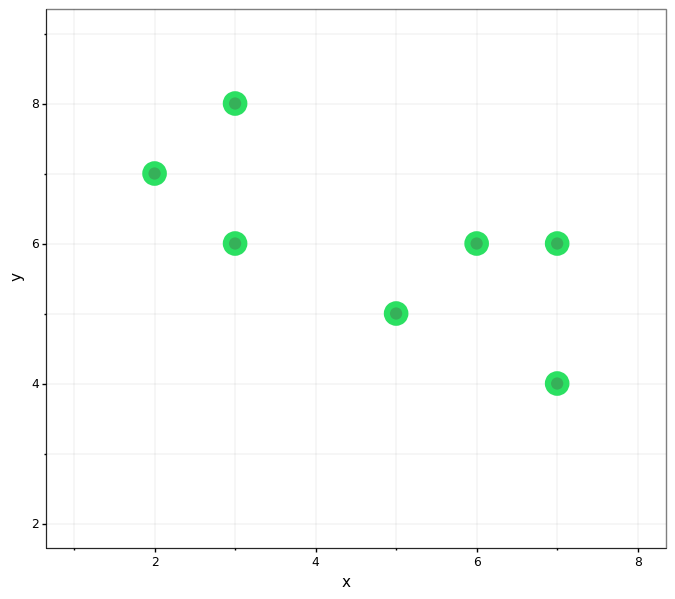

<ggplot: (-9223363263069646648)>

In [121]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(fill = '#36B059', 
               size = 5.0,
               stroke = 2.5,
               colour = '#2BE062',
               shape = 'o') +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(1, 8) +
    ylim(2, 9) +
    theme_bw() + 
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

### Hierarchical clustering

In [122]:
# We start with every point being in the different cluster
clusters = list([[0], [1], [2], [3], [4], [5], [6]])
print(clusters)

[[0], [1], [2], [3], [4], [5], [6]]


In [0]:
# Calculate proximity matrix between all points
from scipy.spatial.distance import pdist, squareform

distances = pdist(cluster_data, metric='euclidean')
proximity_matrix = squareform(distances)
proximity_matrix[np.diag_indices(proximity_matrix.shape[0])] = float('inf')

In [124]:
np.round(proximity_matrix, 2)

array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83, 5.1 ],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47, 4.  ],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66, 4.47],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24, 2.24],
       [4.12, 3.  , 3.61, 1.41,  inf, 2.24, 1.  ],
       [5.83, 4.47, 5.66, 2.24, 2.24,  inf, 2.  ],
       [5.1 , 4.  , 4.47, 2.24, 1.  , 2.  ,  inf]])

Find the coordinates of the smallest distance between points and change the proximity matrix

In [125]:
np.min(proximity_matrix)

1.0

In [126]:
#np.where(proximity_matrix == np.min(proximity_matrix))
print(np.argmin(proximity_matrix)//7)
print(np.argmin(proximity_matrix)%7)

4
6


In [127]:
##### YOUR CODE STARTS #####
fcluster = np.argmin(proximity_matrix)//7
scluster = np.argmin(proximity_matrix)%7
##### YOUR CODE ENDS ##### (please do not delete this line)

print(fcluster)
print(scluster)

4
6


In [128]:
print(f'smallest element is {proximity_matrix[fcluster,scluster]} and {proximity_matrix[scluster,fcluster]}, between clusters {fcluster} and {scluster}')

smallest element is 1.0 and 1.0, between clusters 4 and 6


Merge the two clusters (columns and rows of the matrix), preserving the shortest distance to other clusters from this new cluster (single linkage)

In [129]:
# Given
fcluster = 4
scluster = 6

import copy
new_proximity = copy.deepcopy(proximity_matrix)
print(np.round(new_proximity, 2))

[[ inf 1.41 1.41 3.61 4.12 5.83 5.1 ]
 [1.41  inf 2.   2.24 3.   4.47 4.  ]
 [1.41 2.    inf 3.61 3.61 5.66 4.47]
 [3.61 2.24 3.61  inf 1.41 2.24 2.24]
 [4.12 3.   3.61 1.41  inf 2.24 1.  ]
 [5.83 4.47 5.66 2.24 2.24  inf 2.  ]
 [5.1  4.   4.47 2.24 1.   2.    inf]]


In [0]:
# Copy into the fcluster row and column smallest values from both fcluster and scluster
for i in np.arange(proximity_matrix.shape[0]):
  if proximity_matrix[fcluster, i] > proximity_matrix[scluster, i]:
    ##### YOUR CODE STARTS #####
    new_proximity[fcluster, i] = proximity_matrix[scluster, i]
    new_proximity[i, fcluster] = proximity_matrix[i, scluster]
    ##### YOUR CODE ENDS ##### (please do not delete this line)

In [0]:
# Remove scluster all together
new_proximity = np.delete(new_proximity, scluster, 0)
new_proximity = np.delete(new_proximity, scluster, 1)

In [0]:
# Main diagonal should have infinity values
new_proximity[np.diag_indices(new_proximity.shape[0])] = float('inf')

In [133]:
print(new_proximity.shape)
np.round(new_proximity, 2)

(6, 6)


array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24],
       [4.12, 3.  , 3.61, 1.41,  inf, 2.  ],
       [5.83, 4.47, 5.66, 2.24, 2.  ,  inf]])

In [134]:
# append a scluster to fcluster
clusters[fcluster] += clusters[scluster]
print(clusters)

[[0], [1], [2], [3], [4, 6], [5], [6]]


In [135]:
# remove scluster from clusters (as it now lives elsewhere)
clusters.pop(scluster)
print(clusters)

[[0], [1], [2], [3], [4, 6], [5]]


In [0]:
def merge_clusters(proximity_matrix, fcluster, scluster):
  new_proximity = copy.deepcopy(proximity_matrix)
  ##### YOUR CODE STARTS #####
  for i in np.arange(proximity_matrix.shape[0]):
    if proximity_matrix[fcluster, i] > proximity_matrix[scluster, i]:
      new_proximity[fcluster, i] = proximity_matrix[scluster, i]
      new_proximity[i, fcluster] = proximity_matrix[i, scluster]
  
  # Remove scluster all together
  new_proximity = np.delete(new_proximity, scluster, 0)
  new_proximity = np.delete(new_proximity, scluster, 1)

  # Main diagonal should have infinity values
  new_proximity[np.diag_indices(new_proximity.shape[0])] = float('inf')
  ##### YOUR CODE ENDS ##### (please do not delete this line)

  return(new_proximity)

In [137]:
np.round(merge_clusters(proximity_matrix, 4, 6), 2)

array([[ inf, 1.41, 1.41, 3.61, 4.12, 5.83],
       [1.41,  inf, 2.  , 2.24, 3.  , 4.47],
       [1.41, 2.  ,  inf, 3.61, 3.61, 5.66],
       [3.61, 2.24, 3.61,  inf, 1.41, 2.24],
       [4.12, 3.  , 3.61, 1.41,  inf, 2.  ],
       [5.83, 4.47, 5.66, 2.24, 2.  ,  inf]])

In [138]:
clusters = list([[0], [1], [2], [3], [4], [5], [6]])
distances = np.zeros(proximity_matrix.shape[0])
merging_history = list()
merging_history.append(copy.deepcopy(clusters))
working_matrix = copy.deepcopy(proximity_matrix)

for turn in np.arange(proximity_matrix.shape[0]):
  if (working_matrix.shape[0] == 1):
    break
  ##### YOUR CODE STARTS #####
  fcluster = np.argmin(working_matrix)//working_matrix.shape[0]
  scluster = np.argmin(working_matrix)%working_matrix.shape[0]

  distances[turn] = np.min(working_matrix)
  
  working_matrix = merge_clusters(working_matrix, fcluster, scluster)

  clusters[fcluster] += clusters[scluster]
  clusters.pop(scluster)

  ##### YOUR CODE ENDS ##### (please do not delete this line)
  
  merging_history.append(copy.deepcopy(clusters))

[print(history) for history in merging_history]
print(np.round(distances, 2))

[[0], [1], [2], [3], [4], [5], [6]]
[[0], [1], [2], [3], [4, 6], [5]]
[[0, 1], [2], [3], [4, 6], [5]]
[[0, 1, 2], [3], [4, 6], [5]]
[[0, 1, 2], [3, 4, 6], [5]]
[[0, 1, 2], [3, 4, 6, 5]]
[[0, 1, 2, 3, 4, 6, 5]]
[1.   1.41 1.41 1.41 2.   2.24 0.  ]


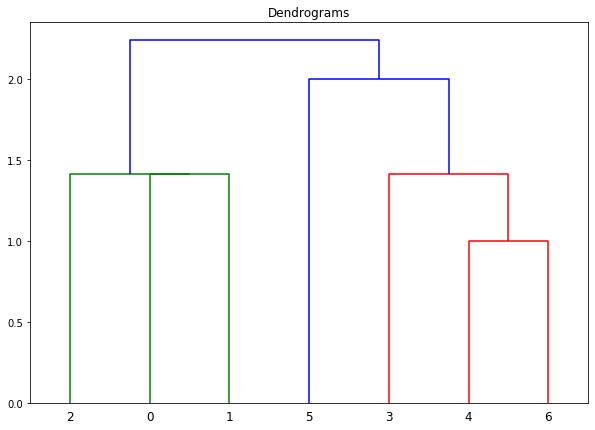

In [139]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(cluster_data, method='single'))

## Hierarchical clusering in `sklearn`

In [0]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(cluster_data)
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

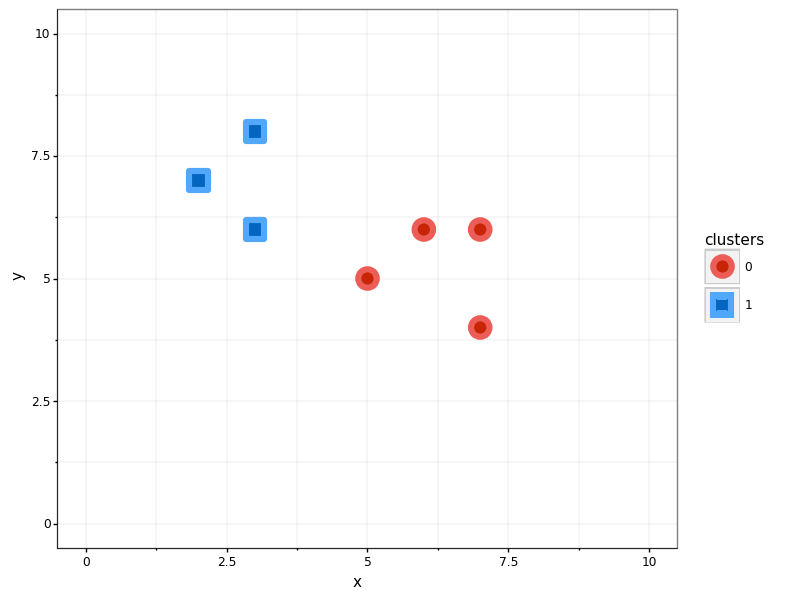

<ggplot: (-9223363263069702428)>

In [141]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

In [0]:
# change the parameters as we can cut the tree earlier
clustering = AgglomerativeClustering(n_clusters = 7).fit(cluster_data)
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

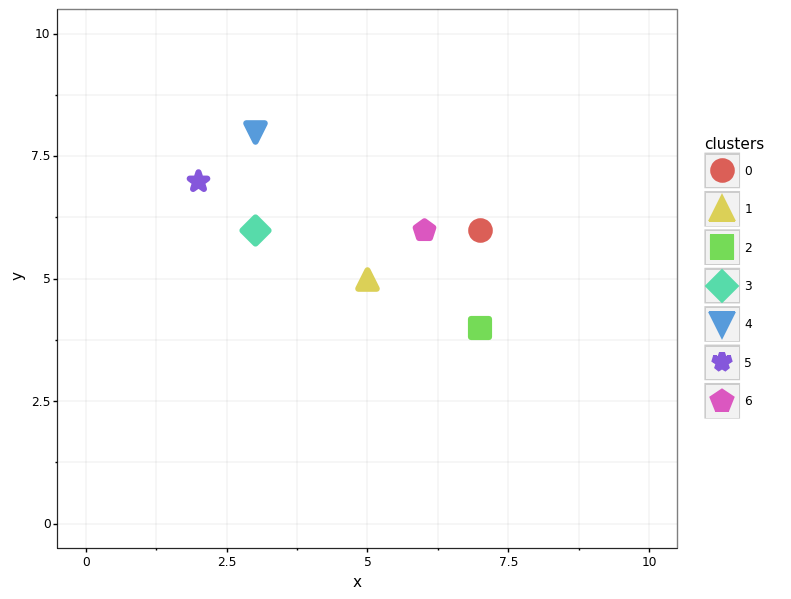

<ggplot: (-9223363263069716406)>

In [143]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() +
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

Let's go back to our lecture slides!

## K-Means

In [0]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=3, random_state=0).fit(cluster_data)
cluster_data['clusters'] = clustering.labels_
cluster_data['clusters'] = cluster_data['clusters'].astype('category')

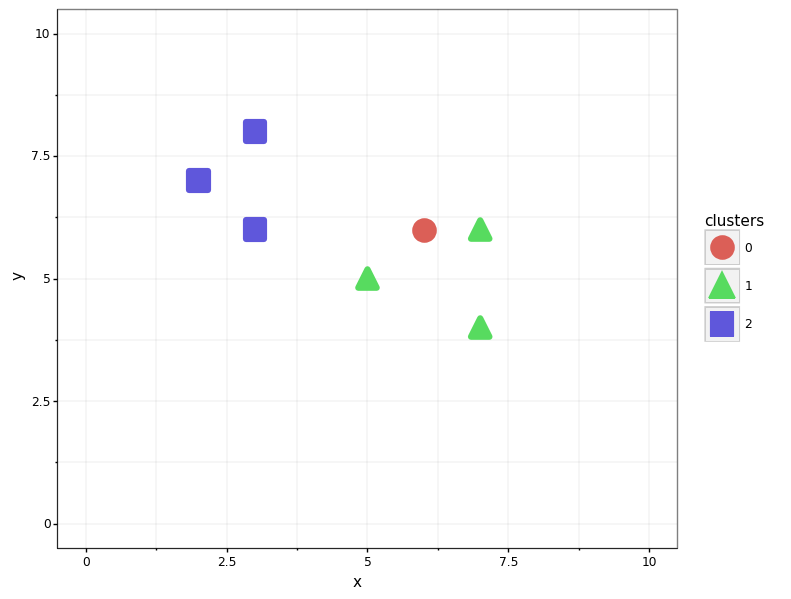

<ggplot: (8773785210169)>

In [145]:
fig = (
    ggplot(data = cluster_data,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_bw() +
    theme(figure_size = (8, 7),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)
fig

## Choosing the right number of clusters

In [0]:
cluster_data = pd.DataFrame({'x':[2,3,3,5,6,7,7], 'y':[7,6,8,5,6,4,6]})

The **rule of thumb** says that `sqrt(n/2)` is a good estimate.

In [147]:
np.sqrt(cluster_data.shape[0]/2)

1.8708286933869707

How many clusters we would end up having with **Elbow method**?

In [148]:
clustering = KMeans(n_clusters=1, random_state=0).fit(cluster_data)
print(clustering.cluster_centers_[0])

# Compute squared sum of errors or simply, a sum of squared euclidean distances from all points to the centroid
def dist(img1, img2):
  return( np.sqrt(np.sum(np.abs(img1 - img2)**2)))
##### YOUR CODE STARTS #####
sse = np.sum([dist(clustering.cluster_centers_[0], point)**2 for point in np.array(cluster_data)])
##### YOUR CODE ENDS ##### (please do not delete this line)
print(sse)

[4.71428571 6.        ]
35.42857142857144


As always, `sklearn` is one step ahead of us...

In [149]:
clustering.inertia_

35.42857142857143

Let's go back to our lecture slides!



## Homework exercise 3 (4 points): Elbow method

<font color='red'>**(a)** Make a function that computes the squared sum of errors (SSE) for given clustering results. (2 points)

In [0]:
##### YOUR CODE STARTS #####
def compute_inertia(clustering, cluster_data):
  clusters = clustering.predict(cluster_data)
  sse = np.sum([dist(clustering.cluster_centers_[cluster], point)**2 for point, cluster in zip(np.array(cluster_data), clusters)])
  
  return(np.sum(sse))
##### YOUR CODE ENDS ##### (please do not delete this line)

Verify that your function works

In [169]:
clustering = KMeans(n_clusters=4, random_state=0).fit(cluster_data)
print(compute_inertia(clustering, cluster_data))
print(clustering.inertia_)


3.1666666666666665
3.1666666666666665


<font color='red'>**(b)** For each K compute corresponding inertia (or SSE) a and plot the **results**. (1 point)

In [170]:
K_options = [1, 2, 3, 4, 5, 6, 7]
##### YOUR CODE STARTS #####
inertia_vec = [compute_inertia(KMeans(n_clusters=k, random_state=0).fit(cluster_data), cluster_data) for k in K_options]
##### YOUR CODE ENDS ##### (please do not delete this line)
print(inertia_vec)

[35.42857142857144, 8.166666666666666, 5.333333333333333, 3.1666666666666665, 1.5000000000000002, 0.5, 0.0]


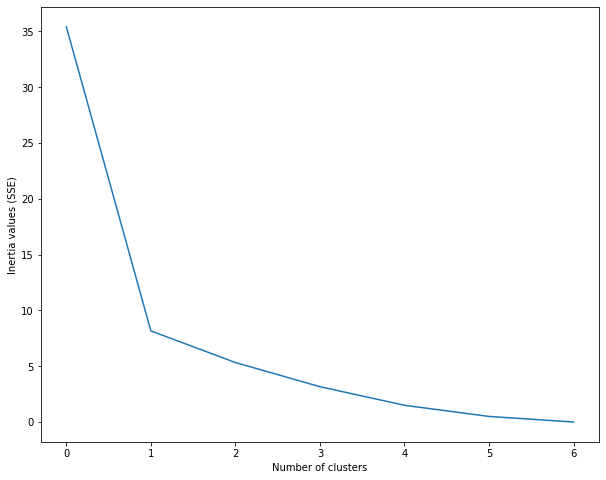

In [171]:
plt.plot(inertia_vec)
plt.ylabel('Inertia values (SSE)')
plt.xlabel('Number of clusters')
plt.show()

<font color='red'>**(c)** Looking at the figure you obtained in **(b)**, what is the most optimal number of clusters? Explain your choice. (1 point)

Answer to **(c)**: Looks like one cluster is the optimal value  ¯\_(ツ)_/¯

## Clustering galery
Here we will indulge ourselves with comparing different clustering algorithms using a panel of interesting datasets.

In [0]:
from sklearn import datasets
n_samples = 100
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_circles_pd = pd.DataFrame({'x':noisy_circles[0][:,0], 'y':noisy_circles[0][:,1], 'clusters':noisy_circles[1]})
noisy_circles_pd['clusters'] = noisy_circles_pd['clusters'].astype('category')

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
noisy_moons_pd = pd.DataFrame({'x':noisy_moons[0][:,0], 'y':noisy_moons[0][:,1], 'clusters':noisy_moons[1]})
noisy_moons_pd['clusters'] = noisy_moons_pd['clusters'].astype('category')

no_structure = np.random.rand(n_samples, 2), None
no_structure_pd = pd.DataFrame({'x':no_structure[0][:,0], 'y':no_structure[0][:,1], 'clusters':np.zeros(len(no_structure[0]))})
no_structure_pd['clusters'] = no_structure_pd['clusters'].astype('category')


In [0]:
noisy_circles_pd['plot_id'] = 'circles'
noisy_moons_pd['plot_id'] = 'moons'
no_structure_pd['plot_id'] = 'nostructure'

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')

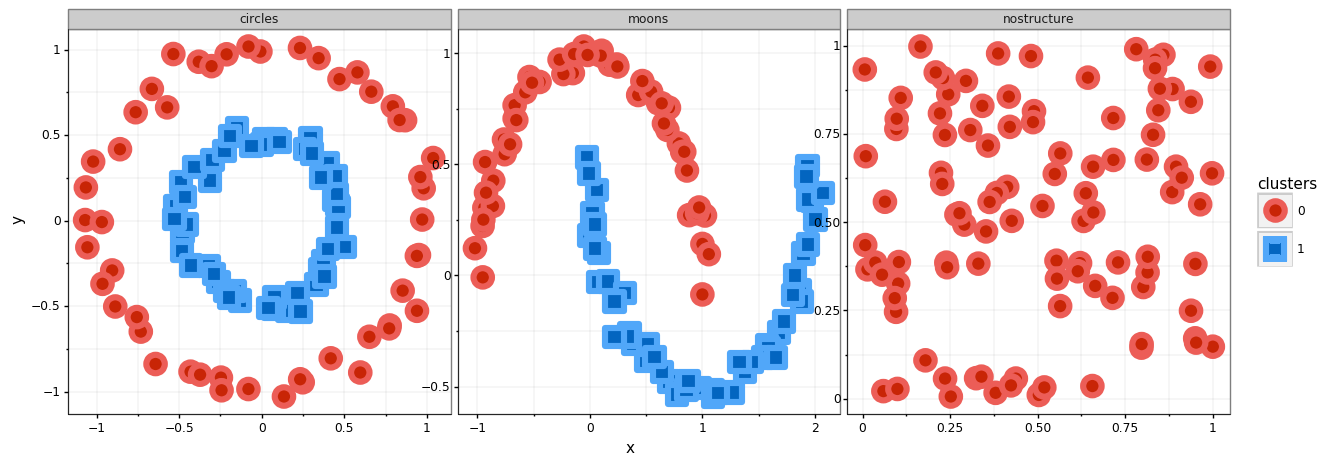

<ggplot: (-9223363263077396669)>

In [174]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'clusters', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

Let's start our degustation from K-means

In [0]:
noisy_circles_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = KMeans(n_clusters=2, random_state=0).fit(no_structure_pd[['x','y']]).labels_

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

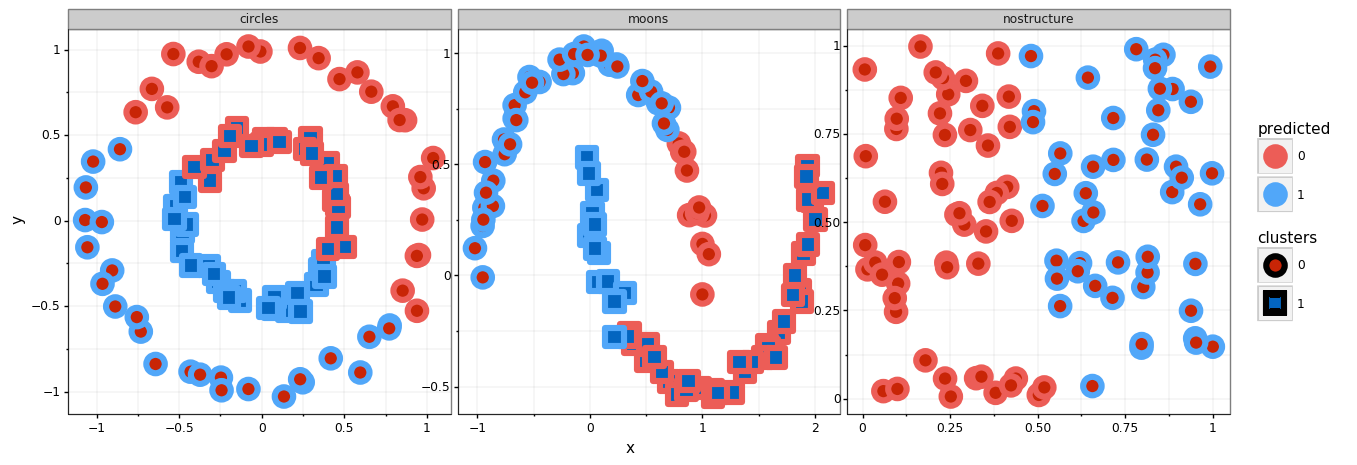

<ggplot: (8773782104363)>

In [176]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

Here is a time for some hierarchical clustering

In [0]:
noisy_circles_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = AgglomerativeClustering(n_clusters = 2).fit(no_structure_pd[['x','y']]).labels_

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

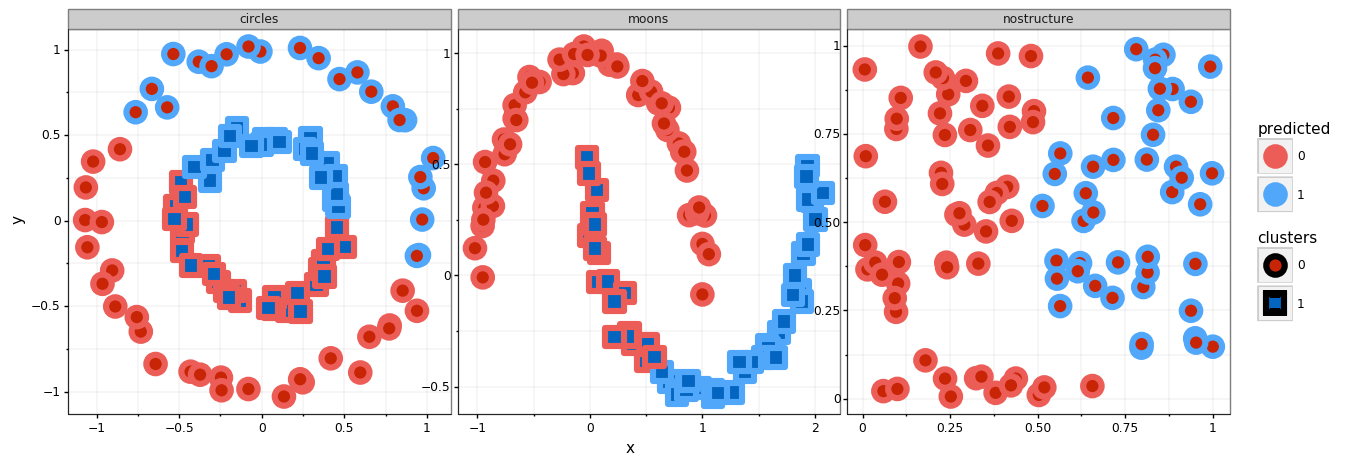

<ggplot: (-9223363263073791807)>

In [178]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

Let's apply DBSCAN as well, as it surely implemented in the `sklearn` package as well. Bellow implement DBSCAN with default parameters (eps = 3 and min_samples = 2).

In [0]:
from sklearn.cluster import DBSCAN
##### YOUR CODE STARTS #####
noisy_circles_pd['predicted'] = DBSCAN().fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = DBSCAN().fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = DBSCAN().fit(no_structure_pd[['x','y']]).labels_
##### YOUR CODE ENDS ##### (please do not delete this line)

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

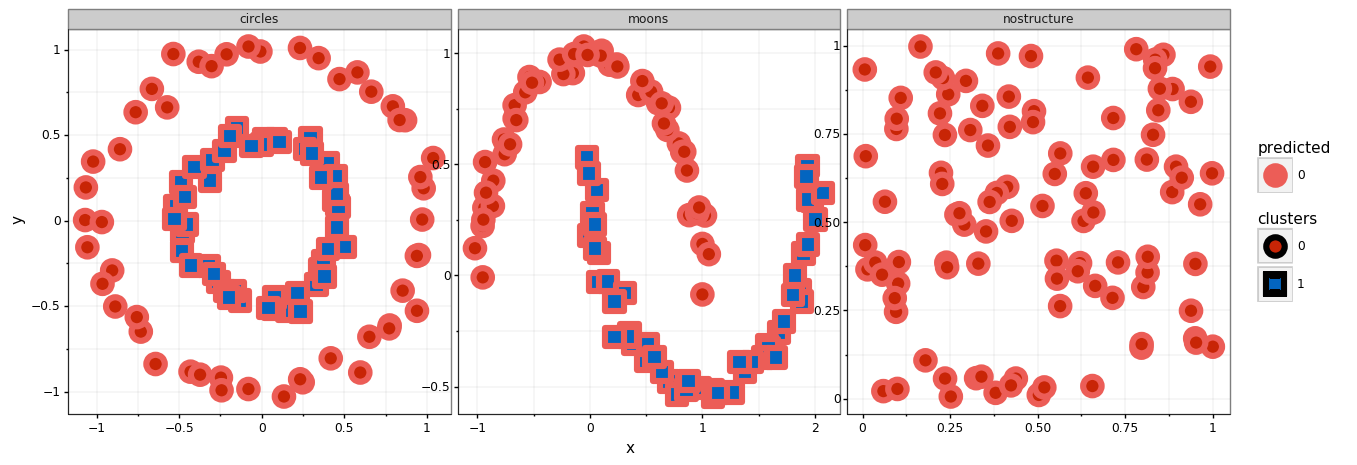

<ggplot: (8773777307477)>

In [180]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

Oops... Something isn't right. What is going on here?

In [0]:
from sklearn.cluster import DBSCAN
##### YOUR CODE STARTS #####
noisy_circles_pd['predicted'] = DBSCAN(eps = 0.32).fit(noisy_circles_pd[['x','y']]).labels_
noisy_moons_pd['predicted'] = DBSCAN(eps = 0.32).fit(noisy_moons_pd[['x','y']]).labels_
no_structure_pd['predicted'] = DBSCAN(eps = 0.32).fit(no_structure_pd[['x','y']]).labels_
##### YOUR CODE ENDS ##### (please do not delete this line)

noisy_data_pd = pd.concat([noisy_circles_pd, noisy_moons_pd, no_structure_pd], axis=0)
noisy_data_pd.shape
noisy_data_pd['plot_id'] = noisy_data_pd['plot_id'].astype('category')
noisy_data_pd['clusters'] = noisy_data_pd['clusters'].astype('category')
noisy_data_pd['predicted'] = noisy_data_pd['predicted'].astype('category')

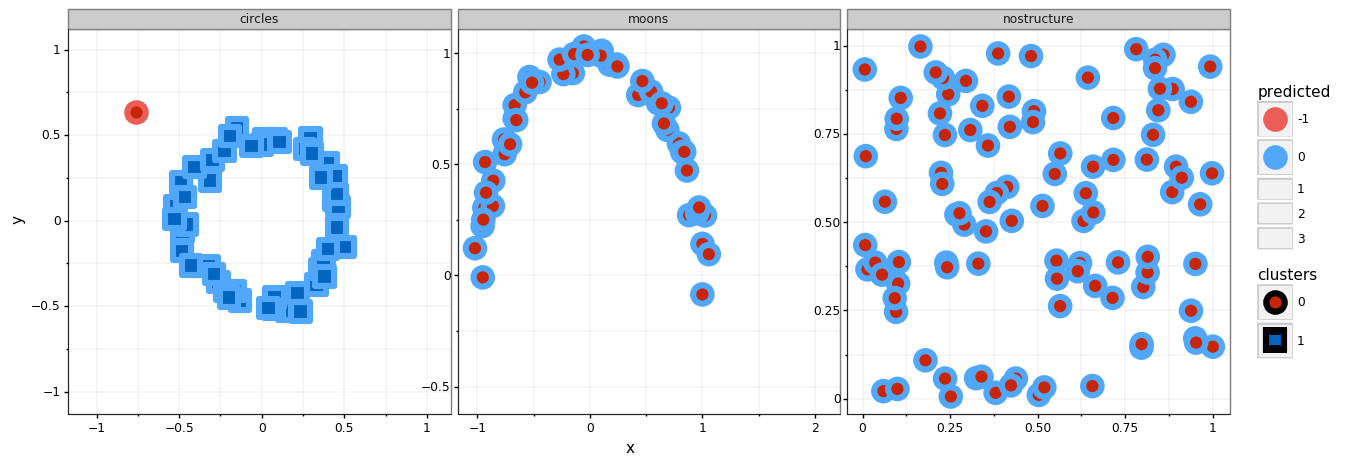

<ggplot: (8773777213637)>

In [182]:
fig = (
    ggplot(data = noisy_data_pd,
          mapping = aes(x = 'x', y = 'y')) +
    geom_point(aes(colour = 'predicted', 
                   shape = 'clusters',
                   fill = 'clusters'), 
               size = 5.0,
               stroke = 2.5) +
    labs(
        title ='',
        x = 'x',
        y = 'y',
    ) +
    theme_bw() + 
    facet_wrap('~plot_id', scales = 'free') + 
    scale_color_manual(['#EC5D57', '#51A7F9']) + 
    scale_fill_manual(['#C82506', '#0365C0']) + 
    scale_shape_manual(['o', 's']) + 
    theme(figure_size = (15, 5),
          axis_line = element_line(size = 0.5, colour = "black"),
          panel_grid_major = element_line(size = 0.05, colour = "black"),
          panel_grid_minor = element_line(size = 0.05, colour = "black"),
          axis_text = element_text(colour ='black'))
)

fig

The End.

# Bonus exercises
*(NB, these are optional exercises!)*

## Bonus exercise 1 (2 bonus points):

<font color='red'> Apply t-SNE or UMAP on MNIST data, plot the results as we have done for PCA. Visually compare the results. Which one in your opinion worked better? What are the advantages and disadvantages of these methods? </font> 

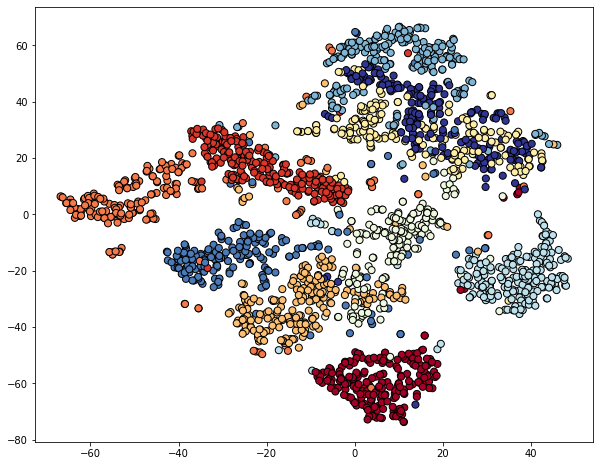

In [186]:
from sklearn.manifold import TSNE

tsne = TSNE()
train_images_new = tsne.fit_transform(train_images).T


visualise_train = pd.DataFrame({'PC1':np.array(train_images_new)[0], 'PC2':np.array(train_images_new)[1]})

cm = plt.cm.get_cmap('RdYlBu')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

plt.scatter(visualise_train.PC1, visualise_train.PC2, s=50, edgecolors = 'black', cmap=cm, c=train_labels)
plt.show()

TSNE looks better as for me. Clusters are more separable.
## pros of t-sne
- handles not only linear dependencies
- preservces global and local structures of the data

## cons
- computational complexity
- requires hyperparameter tuning


## Bonus exercise 2 (2 bonus points):

<font color='red'> Use the output of bonus exercise 1 (either from t-SNE or UMAP) to train your favourite ML model and compare its performance with the same model trained on the original data and on data transformed with conventional PCA. What differences you observe and why? </font> 

In [191]:
model = DecisionTreeClassifier(max_depth=5).fit(train_images, train_labels)
n_correct = sum(model.predict(test_images) == test_labels)
print(f'RAW: On original data DT guessed {n_correct} images')


pca = PCA()
train_images_new = pca.fit_transform(train_images).T
model = DecisionTreeClassifier(max_depth=5).fit(train_images_new[0:n_pc,:].T, train_labels)
test_images_new = pca.transform(test_images).T[0:n_pc,:].T
n_correct = sum(model.predict(test_images_new) == test_labels)
print(f'PCA: On compressed data DT guessed {n_correct} images')


tsne = TSNE()
train_images_new = tsne.fit_transform(train_images)
model = DecisionTreeClassifier(max_depth=5).fit(train_images_new, train_labels)
test_images_new = tsne.fit_transform(test_images)
n_correct = sum(model.predict(test_images_new) == test_labels)
print(f't-sne: On compressed data DT guessed {n_correct} images')

RAW: On original data DT guessed 366 images
PCA: On compressed data DT guessed 518 images
t-sne: On compressed data DT guessed 166 images


Since t-sne doesn't have `transform` method due to specific of t-sne algorithm we should `fit_transform` for train and test. In this way, distribution of transformed data points could be different due to this t-sne shows worse performance.

## Bonus exercise 3 (2 bonus points):

<font color='red'> Pick one more clustering method the `sklearn`, run it on the three datasets we used before (moons, circles and without a structure). Visualise the performance of this new method. And in a few sentences sufficiently explain its principles. </font> 

# Comments (optional feedback to the course instructors)
Here, please, leave your comments regarding the homework, possibly answering the following questions: 
* how much time did you send on this homework?
* was it too hard/easy for you?
* what would you suggest to add or remove?
* anything else you would like to tell us

Your comments: